## Data Import 

In [271]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score

In [199]:
data = pd.read_csv('House_Price.csv')

In [200]:
data.shape

(1460, 81)

In [201]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [202]:
#selecting all columns that do not have numeric values
object_column = data.select_dtypes(include = ['object']).columns.tolist()

## Feature Processing (One Hot Encoding)

In [203]:
#simple one hot encoder function
def one_hot_encoding(data, column_name):

    oh_enc = OneHotEncoder()
    oh_enc.fit(data[[column_name]])
    dummies = pd.DataFrame(oh_enc.transform(data[[column_name]]).todense(), columns=oh_enc.get_feature_names_out(), index = data.index)
    data = data.drop(column_name, axis = 1)

    return data.join(dummies)

In [204]:
for column in object_column:
    data = one_hot_encoding(data, column)
ohc_data = data

<AxesSubplot:>

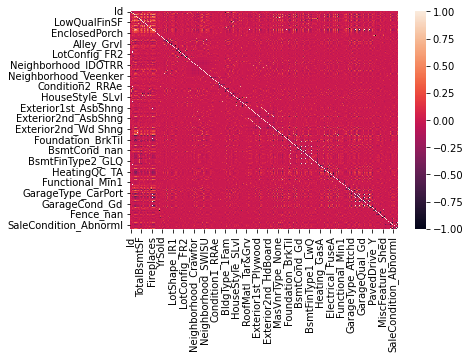

In [205]:
sns.heatmap(ohc_data.corr())

In [206]:
threshold = 0.7

df_corr = ohc_data.corr()

columns = np.full((df_corr.shape[0],), True, dtype=bool)

for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False


selected_columns = ohc_data.columns[~columns]
high_correlation = ohc_data[selected_columns]

In [207]:
absolute_corr = np.abs(df_corr["SalePrice"])
df_corr["SalePrice"][absolute_corr > 0.5]

OverallQual       0.790982
YearBuilt         0.522897
YearRemodAdd      0.507101
TotalBsmtSF       0.613581
1stFlrSF          0.605852
GrLivArea         0.708624
FullBath          0.560664
TotRmsAbvGrd      0.533723
GarageCars        0.640409
GarageArea        0.623431
SalePrice         1.000000
ExterQual_TA     -0.589044
BsmtQual_Ex       0.553105
KitchenQual_Ex    0.504094
KitchenQual_TA   -0.519298
Name: SalePrice, dtype: float64

In [208]:
selected_columns

Index(['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'SalePrice',
       'Neighborhood_Somerst', 'HouseStyle_2Story', 'RoofStyle_Shed',
       'RoofMatl_Tar&Grv', 'Exterior2nd_AsbShng', 'Exterior2nd_CBlock',
       'Exterior2nd_CmentBd', 'Exterior2nd_HdBoard', 'Exterior2nd_MetalSd',
       'Exterior2nd_Plywood', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd',
       'Exterior2nd_Wd Sdng', 'BsmtQual_nan', 'BsmtCond_nan',
       'BsmtExposure_nan', 'BsmtFinType1_nan', 'BsmtFinType2_nan',
       'Electrical_Mix', 'GarageFinish_nan', 'GarageQual_nan', 'GarageCond_Ex',
       'GarageCond_TA', 'GarageCond_nan', 'MiscFeature_Gar2',
       'MiscFeature_TenC', 'SaleCondition_Partial'],
      dtype='object')

In [209]:
high_correlation.corr().head()

,1stFlrSF,TotRmsAbvGrd,GarageYrBlt,GarageArea,SalePrice,Neighborhood_Somerst,HouseStyle_2Story,RoofStyle_Shed,RoofMatl_Tar&Grv,Exterior2nd_AsbShng,...,BsmtFinType2_nan,Electrical_Mix,GarageFinish_nan,GarageQual_nan,GarageCond_Ex,GarageCond_TA,GarageCond_nan,MiscFeature_Gar2,MiscFeature_TenC,SaleCondition_Partial
1stFlrSF,1.000000,0.409516,0.233449,0.489782,0.605852,-0.018495,-0.269813,0.017622,0.071021,-0.063332,...,-0.018376,-0.005801,-0.154846,-0.154846,-0.032741,0.186819,-0.154846,-0.000300,0.015539,0.221037
TotRmsAbvGrd,0.409516,1.000000,0.148112,0.337822,0.533723,-0.015275,0.430930,0.033786,-0.013142,0.002335,...,-0.012382,-0.008343,-0.088285,-0.088285,-0.045995,0.072106,-0.088285,0.045183,0.088332,0.142032
GarageYrBlt,0.233449,0.148112,1.000000,0.564567,0.486362,0.277452,0.186831,-0.000782,-0.050926,-0.136388,...,-0.070103,-0.063858,NaN,NaN,0.013116,0.275846,NaN,-0.015451,-0.000552,0.349327
GarageArea,0.489782,0.337822,0.564567,1.000000,0.623431,0.184533,0.137946,0.020798,-0.006663,-0.092541,...,-0.075543,-0.016534,-0.536333,-0.536333,0.024090,0.485444,-0.536333,-0.003896,0.011149,0.294714
SalePrice,0.605852,0.533723,0.486362,0.623431,1.000000,0.140058,0.242880,0.020557,0.004921,-0.099220,...,-0.145274,-0.037555,-0.236832,-0.236832,-0.026546,0.275872,-0.236832,-0.004744,0.022773,0.352060


## Feature Processing (Label Encoding)

In [222]:
data = pd.read_csv('House_Price.csv')

In [223]:
#simple label encoder function
def label_encoder(data, column_name):
    
    label_encoder = preprocessing.LabelEncoder()
    data[column_name]= label_encoder.fit_transform(data[column_name])
    
    return data

In [224]:
for column in object_column:
    data = label_encoder(data, column)
lc_data = data

<AxesSubplot:>

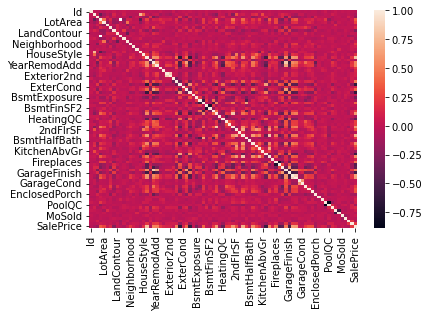

In [225]:
sns.heatmap(lc_data.corr())

In [226]:
threshold = 0.7

df_corr = lc_data.corr()

columns = np.full((df_corr.shape[0],), True, dtype=bool)

for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False


selected_columns = lc_data.columns[~columns]
high_correlation = lc_data[selected_columns]

In [227]:
absolute_corr = np.abs(df_corr["SalePrice"])
df_corr["SalePrice"][absolute_corr > 0.5]

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
ExterQual      -0.636884
BsmtQual       -0.620886
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
KitchenQual    -0.589189
TotRmsAbvGrd    0.533723
GarageFinish   -0.549247
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [228]:
selected_columns

Index(['BldgType', 'Exterior2nd', '1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt',
       'GarageArea', 'SalePrice'],
      dtype='object')

In [230]:
high_correlation.corr()

,BldgType,Exterior2nd,1stFlrSF,TotRmsAbvGrd,GarageYrBlt,GarageArea,SalePrice
BldgType,1.000000,-0.142748,-0.073688,-0.198413,0.200367,-0.061421,-0.085591
Exterior2nd,-0.142748,1.000000,0.017361,0.068503,0.155058,0.095006,0.103766
1stFlrSF,-0.073688,0.017361,1.000000,0.409516,0.233449,0.489782,0.605852
TotRmsAbvGrd,-0.198413,0.068503,0.409516,1.000000,0.148112,0.337822,0.533723
GarageYrBlt,0.200367,0.155058,0.233449,0.148112,1.000000,0.564567,0.486362
GarageArea,-0.061421,0.095006,0.489782,0.337822,0.564567,1.000000,0.623431
SalePrice,-0.085591,0.103766,0.605852,0.533723,0.486362,0.623431,1.000000


## Feature Processing (One Hot and Label Encoding)

In [188]:
data = pd.read_csv('House_Price.csv')

In [233]:
#selecting which columns to use label encoding on
#columns that compare the quality should be used or show that one category is better than
#another category should be used here
lccolumn = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir','KitchenQual','Functional','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence']

In [234]:
#selecting which columns to use one hot encoding on
#ex: Streets should use the one hot encoder because the type of road 
#access should be based on whether it exists or not. 
ohccolumn = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
             'Exterior1st','Exterior2nd', 'MasVnrType', 'Foundation','Heating','Electrical','GarageType','MiscFeature','SaleType','SaleCondition']

In [235]:
for column in ohccolumn:
    data = one_hot_encoding(data, column)

In [236]:
for column in lccolumn:
    data = label_encoder(data, column)

In [237]:
combined_data = data

<AxesSubplot:>

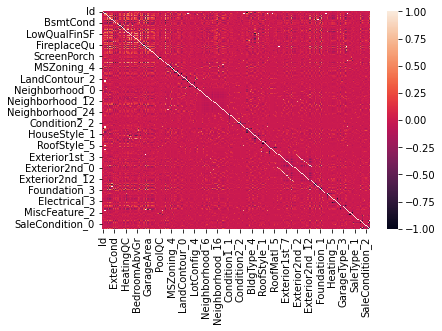

In [238]:
sns.heatmap(combined_data.corr())

In [240]:
threshold = 0.7

df_corr = combined_data.corr()

columns = np.full((df_corr.shape[0],), True, dtype=bool)

for i in range(df_corr.shape[0]):
    for j in range(i+1, df_corr.shape[0]):
        if df_corr.iloc[i,j] >= threshold:
            if columns[j]:
                columns[j] = False


selected_columns = combined_data.columns[~columns]
high_correlation = combined_data[selected_columns]

In [241]:
absolute_corr = np.abs(df_corr["SalePrice"])
df_corr["SalePrice"][absolute_corr > 0.5]

OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
ExterQual      -0.636884
BsmtQual       -0.620886
TotalBsmtSF     0.613581
1stFlrSF        0.605852
GrLivArea       0.708624
FullBath        0.560664
KitchenQual    -0.589189
TotRmsAbvGrd    0.533723
GarageFinish   -0.549247
GarageCars      0.640409
GarageArea      0.623431
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [242]:
selected_columns

Index(['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'SalePrice',
       'Neighborhood_21', 'HouseStyle_5', 'RoofStyle_5', 'RoofMatl_5',
       'Exterior2nd_0', 'Exterior2nd_4', 'Exterior2nd_5', 'Exterior2nd_6',
       'Exterior2nd_8', 'Exterior2nd_10', 'Exterior2nd_12', 'Exterior2nd_13',
       'Exterior2nd_14', 'MiscFeature_0', 'SaleCondition_5'],
      dtype='object')

In [243]:
high_correlation.corr().head()

,1stFlrSF,TotRmsAbvGrd,GarageYrBlt,GarageArea,SalePrice,Neighborhood_21,HouseStyle_5,RoofStyle_5,RoofMatl_5,Exterior2nd_0,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_8,Exterior2nd_10,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,MiscFeature_0,SaleCondition_5
1stFlrSF,1.000000,0.409516,0.233449,0.489782,0.605852,-0.018495,-0.269813,0.017622,0.071021,-0.063332,-0.021856,0.080482,-0.039553,-0.144566,0.110230,0.014831,0.071504,-0.057258,-0.000300,0.221037
TotRmsAbvGrd,0.409516,1.000000,0.148112,0.337822,0.533723,-0.015275,0.430930,0.033786,-0.013142,0.002335,-0.008343,0.048695,-0.035270,-0.113001,-0.029205,0.049522,0.127698,-0.046896,0.045183,0.142032
GarageYrBlt,0.233449,0.148112,1.000000,0.564567,0.486362,0.277452,0.186831,-0.000782,-0.050926,-0.136388,-0.012559,0.113738,-0.047607,-0.198319,-0.055669,-0.136639,0.533014,-0.325996,-0.015451,0.349327
GarageArea,0.489782,0.337822,0.564567,1.000000,0.623431,0.184533,0.137946,0.020798,-0.006663,-0.092541,-0.016534,0.046189,-0.033155,-0.115115,-0.002738,0.001273,0.280274,-0.176492,-0.003896,0.294714
SalePrice,0.605852,0.533723,0.486362,0.623431,1.000000,0.140058,0.242880,0.020557,0.004921,-0.099220,-0.025028,0.128183,-0.067864,-0.162389,-0.052941,-0.042416,0.306389,-0.161800,-0.004744,0.352060


## Log Sale Price

/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


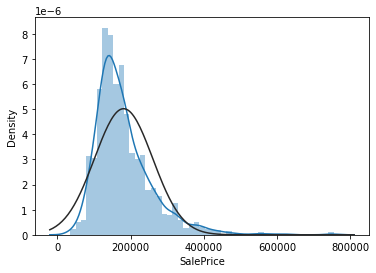

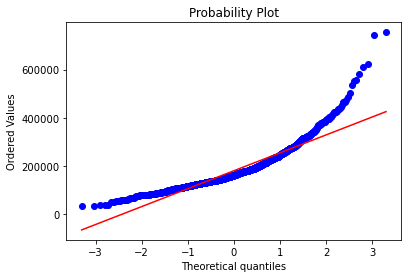

In [244]:
sns.distplot(data['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)

/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


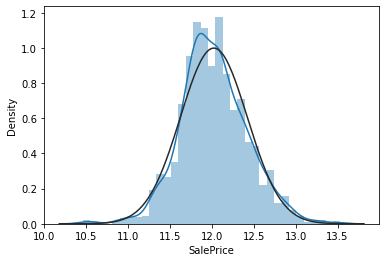

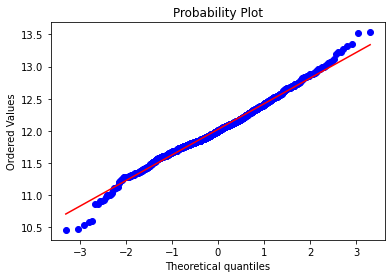

In [245]:
data['SalePrice'] = np.log(data['SalePrice'])
sns.distplot(data['SalePrice'],fit=norm);
fig = plt.figure()
res = stats.probplot(data['SalePrice'], plot=plt)

In [246]:
ohc_data['SalePrice'] = np.log(ohc_data['SalePrice'])
lc_data['SalePrice'] = np.log(lc_data['SalePrice'])
combined_data['SalePrice'] = np.log(combined_data['SalePrice'])

## Random Forest Model (One Hot Encoding)

In [275]:
ohc_data = ohc_data.dropna()
X = ohc_data.drop(['SalePrice', 'Id'], axis = 'columns')
y = ohc_data['SalePrice']

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500)

In [277]:
#made a dataframe with values greater than .001 importance
#sorted the values to look better on bargraph
dataframe = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_)
a = dataframe[dataframe[0] > .001]
a = a.rename(columns = {0: 'values'})
b = a.sort_values('values', ascending = True)
b.head()

,values
KitchenQual_Gd,0.001052
GarageType_Attchd,0.001094
Neighborhood_Crawfor,0.001105
BedroomAbvGr,0.001336
BsmtQual_TA,0.001344


<BarContainer object of 43 artists>

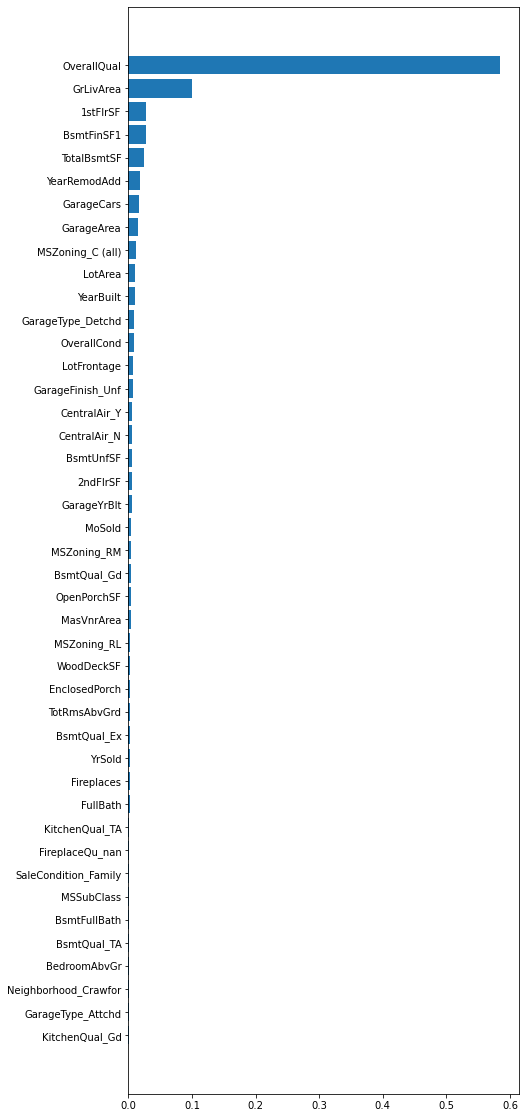

In [278]:
plt.figure(figsize=(7, 20))
plt.barh(b.index, b['values'])

In [279]:
#made another dataframe with a smaller importance threshold
dataframe = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_)
c = dataframe[dataframe[0] > .01]
c = c.rename(columns = {0: 'values'})
d = c.sort_values('values', ascending = True)
d

,values
YearBuilt,0.010038
LotArea,0.010876
MSZoning_C (all),0.011226
GarageArea,0.014903
GarageCars,0.016647
YearRemodAdd,0.018119
TotalBsmtSF,0.023925
BsmtFinSF1,0.027026
1stFlrSF,0.027687
GrLivArea,0.100023


<BarContainer object of 11 artists>

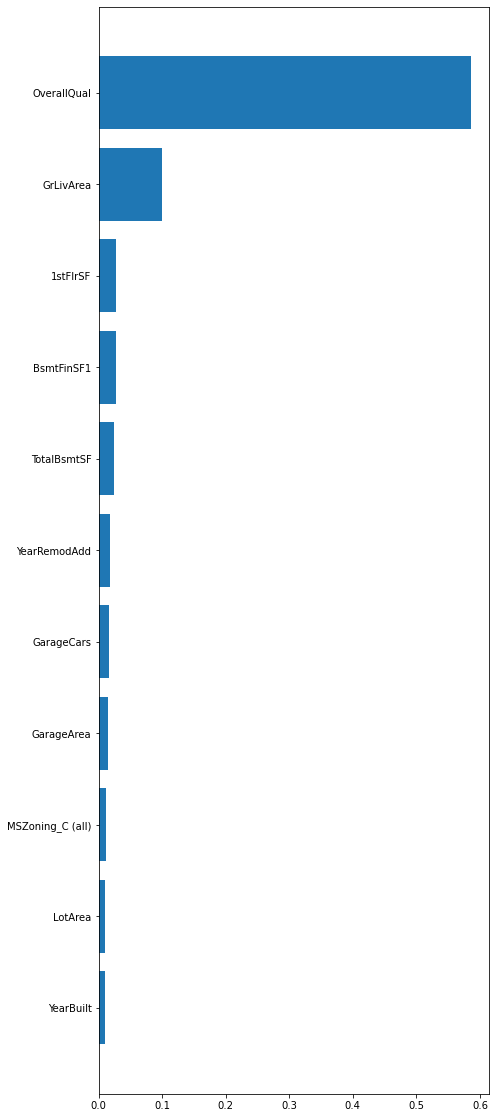

In [280]:
plt.figure(figsize=(7, 20))
plt.barh(d.index, d['values'])

In [281]:
y_output = rf.predict(X_test)

In [282]:
print('MSE', mean_squared_error(y_test, y_output))
print('RMSE', math.sqrt(mean_squared_error(y_test, y_output)))
print('Adj R^2 value:', r2_score(y_test, y_output))

MSE 0.00015939669238290583
RMSE 0.012625240290105604
Adj R^2 value: 0.8646972119979284


## Random Forest Model (Label Encoding)

In [283]:
lc_data = lc_data.dropna()
X = lc_data.drop(['SalePrice', 'Id'], axis = 'columns')
y = lc_data['SalePrice']

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500)

In [285]:
#made a dataframe with values greater than .001 importance
#sorted the values to look better on bargraph
dataframe = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_)
a = dataframe[dataframe[0] > .001]
a = a.rename(columns = {0: 'values'})
b = a.sort_values('values', ascending = True)
b.head()

,values
ExterCond,0.001046
PavedDrive,0.001058
LotShape,0.001081
BsmtFullBath,0.001280
HeatingQC,0.001406


<BarContainer object of 45 artists>

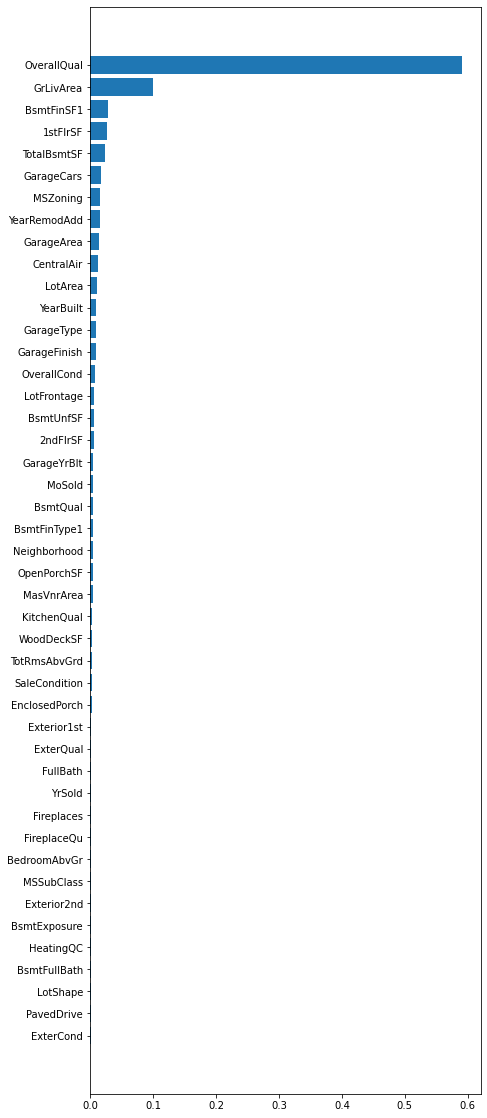

In [286]:
plt.figure(figsize=(7, 20))
plt.barh(b.index, b['values'])

In [287]:
#made another dataframe with a smaller importance threshold
dataframe = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_)
c = dataframe[dataframe[0] > .01]
c = c.rename(columns = {0: 'values'})
d = c.sort_values('values', ascending = True)
d

,values
YearBuilt,0.010009
LotArea,0.011118
CentralAir,0.012362
GarageArea,0.015048
YearRemodAdd,0.016302
MSZoning,0.016428
GarageCars,0.017069
TotalBsmtSF,0.024227
1stFlrSF,0.027335
BsmtFinSF1,0.028313


<BarContainer object of 12 artists>

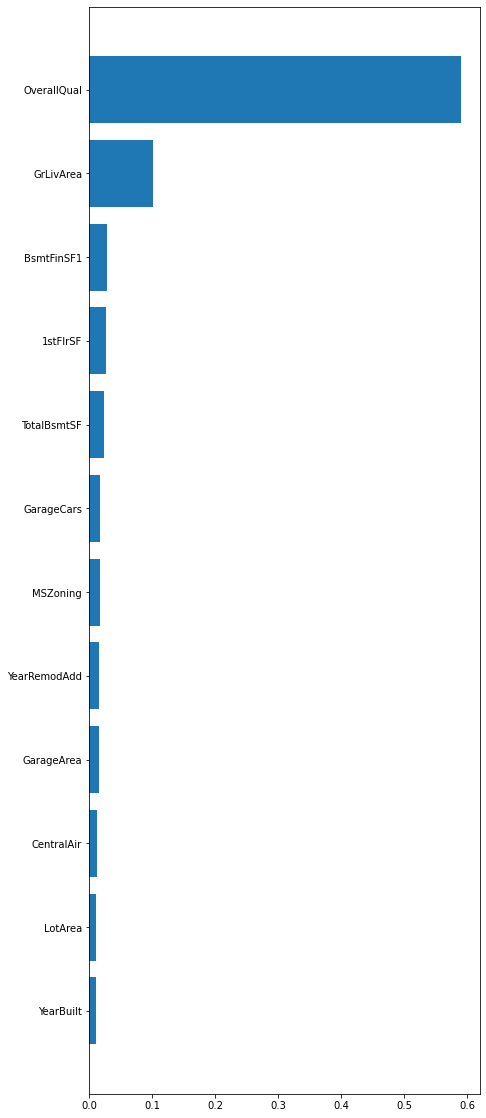

In [288]:
plt.figure(figsize=(7, 20))
plt.barh(d.index, d['values'])

In [289]:
y_output = rf.predict(X_test)

In [290]:
print('MSE', mean_squared_error(y_test, y_output))
print('RMSE', math.sqrt(mean_squared_error(y_test, y_output)))
print('Adj R^2 value:', r2_score(y_test, y_output))

MSE 0.023005903360568784
RMSE 0.15167697043575462
Adj R^2 value: 0.8677688779828006


## Random Forest Model(One Hot and Label Encoding)

In [291]:
combined_data = combined_data.dropna()
X = combined_data.drop(['SalePrice', 'Id'], axis = 'columns')
y = combined_data['SalePrice']

In [292]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500)

In [293]:
#made a dataframe with values greater than .001 importance
#sorted the values to look better on bargraph
dataframe = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_)
a = dataframe[dataframe[0] > .001]
a = a.rename(columns = {0: 'values'})
b = a.sort_values('values', ascending = True)
b.head()

,values
Neighborhood_6,0.001083
GarageType_1,0.001140
PavedDrive,0.001210
ExterCond,0.001253
HeatingQC,0.001290


<BarContainer object of 45 artists>

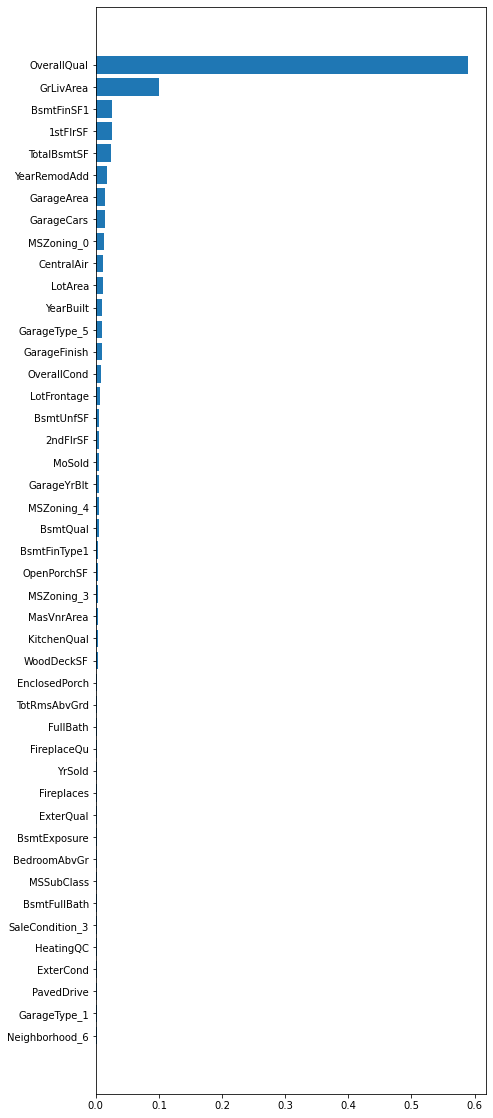

In [294]:
plt.figure(figsize=(7, 20))
plt.barh(b.index, b['values'])

In [295]:
#made another dataframe with a smaller importance threshold
dataframe = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_)
c = dataframe[dataframe[0] > .01]
c = c.rename(columns = {0: 'values'})
d = c.sort_values('values', ascending = True)
d

,values
LotArea,0.011152
CentralAir,0.011860
MSZoning_0,0.013596
GarageCars,0.014533
GarageArea,0.014900
YearRemodAdd,0.017539
TotalBsmtSF,0.023884
1stFlrSF,0.025663
BsmtFinSF1,0.026292
GrLivArea,0.099646


<BarContainer object of 11 artists>

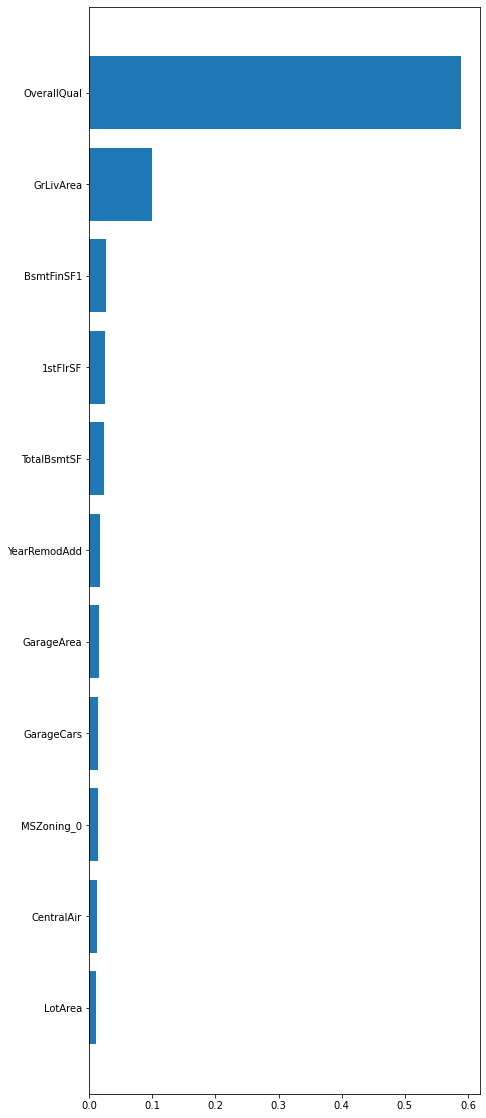

In [296]:
plt.figure(figsize=(7, 20))
plt.barh(d.index, d['values'])

In [297]:
y_output = rf.predict(X_test)

In [298]:
print('MSE', mean_squared_error(y_test, y_output))
print('RMSE', math.sqrt(mean_squared_error(y_test, y_output)))
print('Adj R^2 value:', r2_score(y_test, y_output))

MSE 0.00016092846014439623
RMSE 0.012685758161986072
Adj R^2 value: 0.8633969814498347


## Author Contributions:

Isaac: 

Brandon:

Raj: 